In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
seed = sum([3, 15, 13, 16, 1, 19])
np.random.seed(seed)
num_samples = pd.read_csv('../data/propublica_ours-binary.csv').shape[0]
num_folds = 10

/Users/nlarusstone/.virtualenvs/bbcache/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
def cnf_mat(preds, true):
    # true down, preds across
    true.name = 'True'
    preds.name = 'Preds'
    cnf = pd.crosstab(true, preds)
    print cnf
    tp = cnf.loc[1, 1]
    fp = cnf.loc[0, 1]
    fn = cnf.loc[1, 0]
    tn = cnf.loc[0, 0]
    print 'TPR: {0}'.format(float(tp) / (tp + fn))
    print 'FPR: {0}'.format(float(fp) / (fp + tn))
    print 'TP: {0}, FP: {1}, FN: {2}, TN: {3}'.format(tp, fp, fn, tn)
    print confusion_matrix(true, preds)
    print classification_report(true, preds)
    return [tp, fp, fn, tn]

def calc_rates(samps, pred_arr, true_arr, compas_arr=None):
    preds = pred_arr.loc[samps.astype(bool)]
    compas = compas_arr.loc[samps.astype(bool)]
    true = true_arr.loc[samps.astype(bool)]
    print 'CORELS'
    corels_cnf = cnf_mat(preds, true)
    print compas.shape, true.shape
    print 'COMPAS'
    compas_cnf = cnf_mat(compas, true)
    print compas_cnf[1]
    return corels_cnf, compas_cnf

In [4]:
bin = pd.read_csv('../data/propublica_ours.csv')
bin.head()

,sex,age,race,juvenile-felonies,juvenile-misdemeanors,juvenile-crimes,priors,recidivate-within-two-years
0,Male,>45,Other,=0,=0,=0,=0,0
1,Male,26-45,African-American,=0,=0,=0,=0,1
2,Male,21-22,African-American,=0,=0,>0,>3,1
3,Male,26-45,Other,=0,=0,=0,=0,0
4,Male,26-45,Caucasian,=0,=0,=0,>3,1


In [5]:
for i in range(num_folds):
    fname = '../logs/for-compas_{0}_train.out-curious_lb-with_prefix_perm_map-minor-removed=none-max_num_nodes=100000000-c=0.0050000-v=progress-f=1000-opt.txt'.format(i)
    with open(fname, 'r') as f:
        line = f.readlines()
        print line

['{sex:Male,age:18-20}~1;{age:21-22,priors:2-3}~1;{priors:>3}~1;default~0']
['{sex:Male,age:18-20}~1;{age:21-22,priors:2-3}~1;{priors:>3}~1;default~0']
['{sex:Male,age:18-20}~1;{age:21-22,priors:2-3}~1;{priors:>3}~1;{age:23-25,priors:2-3}~1;default~0']
['{age:21-22,priors:2-3}~1;{age:23-25,priors:2-3}~1;{priors:>3}~1;{sex:Male,age:18-20}~1;default~0']
['{sex:Male,age:18-20}~1;{age:21-22,priors:2-3}~1;{priors:>3}~1;default~0']
['{age:21-22,priors:2-3}~1;{priors:>3}~1;{sex:Male,age:18-20}~1;default~0']
['{sex:Male,age:18-20}~1;{age:21-22,priors:2-3}~1;{age:23-25,priors:2-3}~1;{priors:>3}~1;default~0']
['{sex:Male,age:18-20}~1;{age:21-22,priors:2-3}~1;{priors:>3}~1;default~0']
['{age:21-22,priors:2-3}~1;{priors:>3}~1;{sex:Male,age:18-20}~1;default~0']
['{sex:Male,age:18-20}~1;{priors:>3}~1;{age:21-22,priors:2-3}~1;default~0']


In [6]:
for i in range(num_folds):
    fname = '../jmlr/for-propublica_ours_{0}_train.out-curious_lb-with_prefix_perm_map-minor-removed=none-max_num_nodes=1000000000-c=0.0050000-v=10-f=1000-opt.txt'.format(i)
    with open(fname, 'r') as f:
        line = f.readlines()
        print line

['{age:21-22,priors:2-3}~1;{sex:Male,age:18-20}~1;{priors:>3}~1;default~0']
['{age:21-22,priors:2-3}~1;{sex:Male,age:18-20}~1;{priors:>3}~1;default~0']
['{age:23-25,priors:2-3}~1;{sex:Male,age:18-20}~1;{age:21-22,priors:2-3}~1;{priors:>3}~1;default~0']
['{age:23-25,priors:2-3}~1;{age:21-22,priors:2-3}~1;{priors:>3}~1;{sex:Male,age:18-20}~1;default~0']
['{sex:Male,age:18-20}~1;{age:21-22,priors:2-3}~1;{priors:>3}~1;default~0']
['{age:21-22,priors:2-3}~1;{priors:>3}~1;{sex:Male,age:18-20}~1;default~0']
['{age:23-25,priors:2-3}~1;{sex:Male,age:18-20}~1;{priors:>3}~1;{age:21-22,priors:2-3}~1;default~0']
['{age:21-22,priors:2-3}~1;{sex:Male,age:18-20}~1;{priors:>3}~1;default~0']
['{priors:>3}~1;{sex:Male,age:18-20}~1;{age:21-22,priors:2-3}~1;default~0']
['{age:21-22,priors:2-3}~1;{sex:Male,age:18-20}~1;{priors:>3}~1;default~0']


In [57]:
for i in range(num_folds):
    fname = '../jmlr/for-compas_{0}_train.out-curious_lb-with_prefix_perm_map-minor-removed=none-max_num_nodes=1000000000-c=0.0050000-v=10-f=1000.txt'.format(i)
    with open(fname, 'r') as f:
        line = f.readlines()
        print line[-1].split(',')[0]

21.4483
49.3778
77.9671
77.8193
48.6318
105.87
119.704
35.0397
23.4312
26.5008


In [7]:
def analyze_data(froot='compas', train=True):
    labels = ['Black (CORELS)', 'Black (COMPAS)', 'White (CORELS)', 'White (COMPAS)']
    white_corels, white_compas, black_corels, black_compas = [], [], [], []
    train_or_test = 'train' if train else 'test'
    for i in range(num_folds):
        print i
        if froot == 'compas':
            fname = '../logs/for-{0}_{1}_{2}.out-curious_lb-with_prefix_perm_map-minor-removed=none-max_num_nodes=100000000-c=0.0050000-v=progress-f=1000-opt.txt'.format(froot, i, train_or_test)
        elif froot == 'propublica_ours':
            fname = '../jmlr/for-{0}_{1}_{2}.out-curious_lb-with_prefix_perm_map-minor-removed=none-max_num_nodes=1000000000-c=0.0050000-v=10-f=1000-opt.txt'.format(froot, i, train_or_test)
        else:
            print 'NOT A VALID FROOT'
            return
        with open(fname, 'r') as f:
            line = f.readline()
            opt = map(lambda x: x.split('~'), line.split(';'))
            print opt

        nrules = 0
        with open('../data/CrossValidation/score_{0}_{1}.out'.format(i, train_or_test)) as f:
            line = f.readline()
            nrules = len(line.split()) - 1
        race = pd.read_csv('../data/CrossValidation/score_{0}_{1}.out'.format(i, train_or_test), sep=' ', names=['Rule'] + range(nrules))
        race.set_index('Rule', inplace=True)
        compas = pd.read_csv('../data/CrossValidation/score_{0}_{1}.label'.format(i, train_or_test), sep=' ', names=['Rule'] + range(nrules))
        compas.set_index('Rule', inplace=True)
        compas_i = compas.loc['{score:Yes}']
        black = race.loc['{race:African-American}']
        white = race.loc['{race:Caucasian}']

        nrules = 0
        with open('../data/CrossValidation/{0}_{1}_{2}.out'.format(froot, i, train_or_test)) as f:
            line = f.readline()
            nrules = len(line.split()) - 1
        out = pd.read_csv('../data/CrossValidation/{0}_{1}_{2}.out'.format(froot, i, train_or_test), sep=' ', names=['Rule'] + range(nrules))
        label = pd.read_csv('../data/CrossValidation/{0}_{1}_{2}.label'.format(froot, i, train_or_test), sep=' ', names=['Rule'] + range(nrules))
        out.set_index('Rule', inplace=True)
        label.set_index('Rule', inplace=True)

        captured = set()
        preds = []
        for (rule, pred) in opt[:-1]:
            cappd = out.ix[rule] == 1
            unfiltered_cappd = out.T[cappd].index
            filtered_cappd = set(unfiltered_cappd).difference(captured)
            preds += map(lambda x: (x, pred), filtered_cappd)
            captured = captured.union(filtered_cappd)

        # Handle default rule
        _, def_pred = opt[-1]
        preds += [(x, def_pred) for x in set(range(nrules)).difference(captured)]
        sorted_preds = sorted(preds, key=lambda x: x[0])
        pred_arr = pd.Series(map(lambda x: int(x[1]), sorted_preds))
        true_arr = label.iloc[1, :]
        print black.shape, pred_arr.shape, true_arr.shape, compas_i.shape
        print 'BLACK'
        black_corels_cnf, black_compas_cnf = calc_rates(black, pred_arr, true_arr, compas_arr=compas_i)
        print 'WHITE'
        white_corels_cnf, white_compas_cnf = calc_rates(white, pred_arr, true_arr, compas_arr=compas_i)

        black_corels.append(black_corels_cnf)
        black_compas.append(black_compas_cnf)
        white_corels.append(white_corels_cnf)
        white_compas.append(white_compas_cnf)
    algs = zip(labels, [black_corels, black_compas, white_corels, white_compas])
    return algs

In [8]:
algs = analyze_data(froot='compas', train=True)

0
[['{sex:Male,age:18-20}', '1'], ['{age:21-22,priors:2-3}', '1'], ['{priors:>3}', '1'], ['default', '0']]
(6216,) (6216,) (6216,) (6216,)
BLACK
CORELS
Preds    0     1
True            
0      957   543
1      565  1134
TPR: 0.667451442025
FPR: 0.362
TP: 1134, FP: 543, FN: 565, TN: 957
[[ 957  543]
 [ 565 1134]]
             precision    recall  f1-score   support

          0       0.63      0.64      0.63      1500
          1       0.68      0.67      0.67      1699

avg / total       0.65      0.65      0.65      3199

(3199,) (3199,)
COMPAS
Preds    0     1
True            
0      837   663
1      469  1230
TPR: 0.723955267805
FPR: 0.442
TP: 1230, FP: 663, FN: 469, TN: 837
[[ 837  663]
 [ 469 1230]]
             precision    recall  f1-score   support

          0       0.64      0.56      0.60      1500
          1       0.65      0.72      0.68      1699

avg / total       0.65      0.65      0.64      3199

663
WHITE
CORELS
Preds     0    1
True            
0      1008  271
1  

In [20]:
x

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]

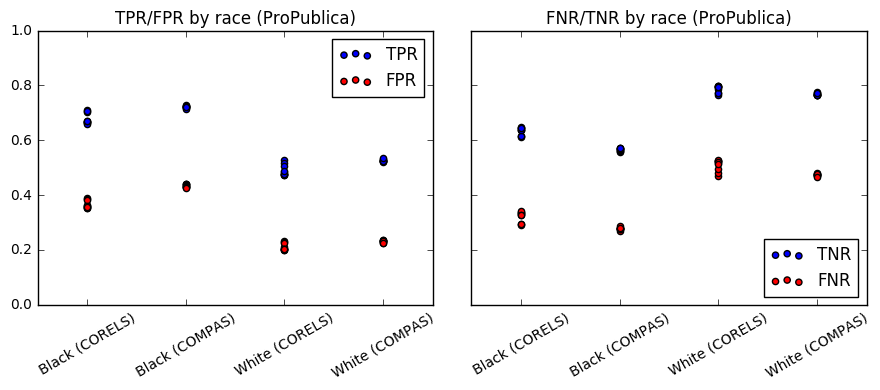

In [40]:
# tp, fp, fn, tn
def tpr(l):
    return map(lambda x: float(x[0]) / (x[0] + x[2]), l)
def fpr(l):
    return map(lambda x: float(x[1]) / (x[1] + x[3]), l)
def fnr(l):
    return map(lambda x: float(x[2]) / (x[0] + x[2]), l)
def tnr(l):
    return map(lambda x: float(x[3]) / (x[1] + x[3]), l)
x = [[i] * num_folds for i in range(len(algs))]
y_tp = [tpr(a[1]) for a in algs]
y_fp = [fpr(a[1]) for a in algs]
y_fn = [fnr(a[1]) for a in algs]
y_tn = [tnr(a[1]) for a in algs]
labels = [l[0] for l in algs]
f, axs = plt.subplots(1, 2, figsize=(9,4), sharey=True)
types = ['TPR/FPR', 'FNR/TNR']
#[[ax1, ax2], [ax3, ax4]] = axs
ax1, ax2 = axs
ax1.scatter(x, y_tp, c='blue')
ax1.scatter(x, y_fp, c='red')
ax1.legend(['TPR', 'FPR'])
ax2.scatter(x, y_tn, c='blue')
ax2.scatter(x, y_fn, c='red')
ax2.legend(['TNR', 'FNR'], loc='lower right')
#for ax in [ax1, ax2]:
#    ax.set_xticks([])
for ix, ax in enumerate([ax1, ax2]):
    ax.set_xticks(range(len(algs)))
    ax.set_ylim([0, 1])
    ax.set_xticklabels(labels, rotation=30)
    ax.set_title('{0} by race (ProPublica)'.format(types[ix]))
#for ix, t in np.ndenumerate(types):
#    axs[ix].set_ylabel(t)
 #   axs[ix].set_title('{0} by race (ProPublica)'.format(t))
    
plt.tight_layout()
plt.savefig('../figs/compas-corels-comparison.pdf')
plt.show()

In [46]:
train = True
froot = 'compas'
labels = ['Black (CORELS)', 'Black (COMPAS)', 'White (CORELS)', 'White (COMPAS)']
white_corels, white_compas, black_corels, black_compas = [], [], [], []
train_or_test = 'train' if train else 'test'
for i in range(num_folds):
    print i
    if froot == 'compas':
        fname = '../logs/for-{0}_{1}_{2}.out-curious_lb-with_prefix_perm_map-minor-removed=none-max_num_nodes=100000000-c=0.0050000-v=progress-f=1000-opt.txt'.format(froot, i, train_or_test)
    elif froot == 'propublica_ours':
        fname = '../jmlr/for-{0}_{1}_{2}.out-curious_lb-with_prefix_perm_map-minor-removed=none-max_num_nodes=1000000000-c=0.0050000-v=10-f=1000-opt.txt'.format(froot, i, train_or_test)
    else:
        print 'NOT A VALID FROOT'
    with open(fname, 'r') as f:
        line = f.readline()
        opt = map(lambda x: x.split('~'), line.split(';'))
        print opt

    nrules = 0
    with open('../data/CrossValidation/score_{0}_{1}.out'.format(i, train_or_test)) as f:
        line = f.readline()
        nrules = len(line.split()) - 1
    race = pd.read_csv('../data/CrossValidation/score_{0}_{1}.out'.format(i, train_or_test), sep=' ', names=['Rule'] + range(nrules))
    race.set_index('Rule', inplace=True)
    compas = pd.read_csv('../data/CrossValidation/score_{0}_{1}.label'.format(i, train_or_test), sep=' ', names=['Rule'] + range(nrules))
    compas.set_index('Rule', inplace=True)
    compas_i = compas.loc['{score:Yes}']
    black = race.loc['{race:African-American}']
    white = race.loc['{race:Caucasian}']

    nrules = 0
    with open('../data/CrossValidation/{0}_{1}_{2}.out'.format(froot, i, train_or_test)) as f:
        line = f.readline()
        nrules = len(line.split()) - 1
    out = pd.read_csv('../data/CrossValidation/{0}_{1}_{2}.out'.format(froot, i, train_or_test), sep=' ', names=['Rule'] + range(nrules))
    label = pd.read_csv('../data/CrossValidation/{0}_{1}_{2}.label'.format(froot, i, train_or_test), sep=' ', names=['Rule'] + range(nrules))
    out.set_index('Rule', inplace=True)
    label.set_index('Rule', inplace=True)

    captured = set()
    preds = []
    for (rule, pred) in opt[:-1]:
        cappd = out.ix[rule] == 1
        unfiltered_cappd = out.T[cappd].index
        filtered_cappd = set(unfiltered_cappd).difference(captured)
        preds += map(lambda x: (x, pred), filtered_cappd)
        captured = captured.union(filtered_cappd)

    # Handle default rule
    _, def_pred = opt[-1]
    preds += [(x, def_pred) for x in set(range(nrules)).difference(captured)]
    sorted_preds = sorted(preds, key=lambda x: x[0])
    pred_arr = pd.Series(map(lambda x: int(x[1]), sorted_preds))
    true_arr = label.iloc[1, :]
    break

0
[['{sex:Male,age:18-20}', '1'], ['{age:21-22,priors:2-3}', '1'], ['{priors:>3}', '1'], ['default', '0']]


In [59]:
df = pd.read_csv('../compas/compas-scores-two-years.csv')

In [60]:
df.columns

Index([u'id', u'name', u'first', u'last', u'compas_screening_date', u'sex',
       u'dob', u'age', u'age_cat', u'race', u'juv_fel_count', u'decile_score',
       u'juv_misd_count', u'juv_other_count', u'priors_count',
       u'days_b_screening_arrest', u'c_jail_in', u'c_jail_out',
       u'c_case_number', u'c_offense_date', u'c_arrest_date',
       u'c_days_from_compas', u'c_charge_degree', u'c_charge_desc',
       u'is_recid', u'r_case_number', u'r_charge_degree',
       u'r_days_from_arrest', u'r_offense_date', u'r_charge_desc',
       u'r_jail_in', u'r_jail_out', u'violent_recid', u'is_violent_recid',
       u'vr_case_number', u'vr_charge_degree', u'vr_offense_date',
       u'vr_charge_desc', u'type_of_assessment', u'decile_score.1',
       u'score_text', u'screening_date', u'v_type_of_assessment',
       u'v_decile_score', u'v_score_text', u'v_screening_date', u'in_custody',
       u'out_custody', u'priors_count.1', u'start', u'end', u'event',
       u'two_year_recid'],
      dtype

In [62]:
black = df[df['race'] == 'African-American']
black_juv = black['juv_fel_count'] + black['juv_misd_count'] + black['juv_other_count']
black_juv.mean()

0.37148268398268397

In [63]:
white = df[df['race'] == 'Caucasian']
white_juv = white['juv_fel_count'] + white['juv_misd_count'] + white['juv_other_count']
white_juv.mean()

0.16055419722901385

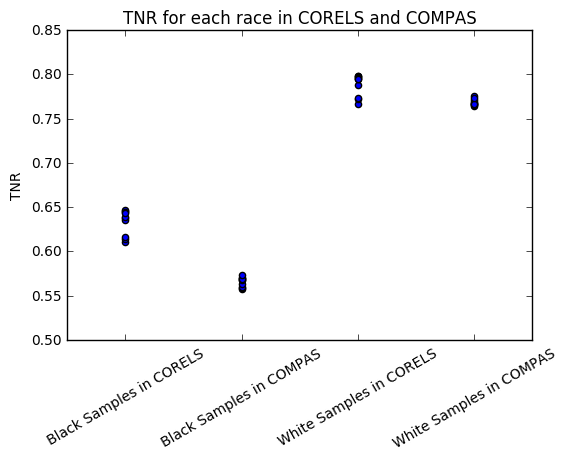

In [23]:
plt.scatter(x, y_tn)
plt.xticks(range(len(algs)), labels, rotation=30)
plt.ylabel('TNR')
plt.title('TNR for each race in CORELS and COMPAS')
plt.show()

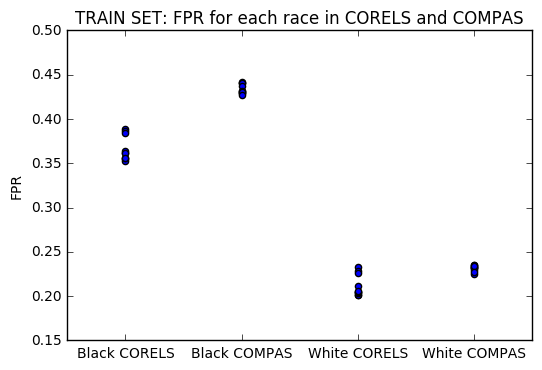

In [54]:
def fpr(l):
    return map(lambda x: float(x[1]) / (x[1] + x[3]), l)
x_fp = [[i] * num_folds for i in range(len(algs))]
y_fp = [fpr(a[1]) for a in algs]
labels = [l[0] for l in algs]
plt.scatter(x_fp, y_fp)
plt.xticks(range(len(algs)), labels)
plt.ylabel('FPR')
plt.title('TRAIN SET: FPR for each race in CORELS and COMPAS')
plt.show()

In [29]:
def stats(l):
    print 'TP, FP, FN, TN'
    print 'Means:', np.mean(l, axis=0)
    print 'Std deviations:', np.std(l, axis=0)
for a in algs:
    print a[0]
    stats(a[1])

Black CORELS
TP, FP, FN, TN
Means: [ 1118.3   560.3   592.6  1053.4]
Std deviations: [ 97.53773629  53.20159772  88.66701754  57.42159872]
Black COMPAS
TP, FP, FN, TN
Means: [ 1232.1   724.5   478.8   889.2]
Std deviations: [ 10.61555463   7.83900504   8.36420947   6.89637586]
White CORELS
TP, FP, FN, TN
Means: [  406.4   270.5   463.   1068.7]
Std deviations: [ 35.31345353  28.876461    38.69625305  32.69877674]
White COMPAS
TP, FP, FN, TN
Means: [  454.5   314.1   414.9  1025.1]
Std deviations: [ 4.41021541  4.15812458  7.81600921  6.36317531]


In [ ]:
# tp, fp, fn, tn
# FPR: float(fp) / (fp + tn)
# TPR: float(tp) / (tp + fn)

In [ ]:
white.sum() + black.sum()

In [ ]:
white.sum()

In [ ]:
pred_arr.sum()

In [ ]:
compas_preds.sum()

In [ ]:
def analyze_data(train=True):
    binary = pd.read_csv('../data/propublica_ours-binary.csv')
    np.random.seed(seed)
    splits = np.split(np.random.permutation(num_samples / num_folds * num_folds), num_folds)
    compas = pd.read_csv('../compas/compas-scores-two-years.csv')
    compas = compas[compas['c_jail_in'] != '']
    compas_scores = compas['decile_score']
    compas_preds = (compas_scores > 4).astype(int)
    labels = ['Black CORELS', 'Black COMPAS', 'White CORELS', 'White COMPAS']
    white_corels, white_compas, black_corels, black_compas = [], [], [], []
    train_or_test = 'train' if train else 'test'
    for i in range(num_folds):
        print i
        fname = '../logs/for-compas_{0}_train.out-curious_lb-with_prefix_perm_map-minor-removed=none-max_num_nodes=100000000-c=0.0050000-v=progress-f=1000-opt.txt'.format(i)
        with open(fname, 'r') as f:
            line = f.readline()
            opt = map(lambda x: x.split('~'), line.split(';'))
            print opt
        
        if train:
            split_i = np.concatenate([splits[j] for j in range(num_folds) if (j != i)])
        else:
            split_i = splits[i]
        bin_i = binary.loc[split_i].reset_index(drop=True).T
        compas_i = compas_preds.loc[split_i].reset_index(drop=True)
        black = bin_i.loc['race:African-American']
        white = bin_i.loc['race:Caucasian']

        nrules = 0
        with open('../data/CrossValidation/compas_{0}_{1}.out'.format(i, train_or_test)) as f:
            line = f.readline()
            nrules = len(line.split()) - 1
        out = pd.read_csv('../data/CrossValidation/compas_{0}_{1}.out'.format(i, train_or_test), sep=' ', names=['Rule'] + range(nrules))
        label = pd.read_csv('../data/CrossValidation/compas_{0}_{1}.label'.format(i, train_or_test), sep=' ', names=['Rule'] + range(nrules))
        out.set_index('Rule', inplace=True)
        label.set_index('Rule', inplace=True)

        captured = set()
        preds = []
        for (rule, pred) in opt[:-1]:
            cappd = out.ix[rule] == 1
            unfiltered_cappd = out.T[cappd].index
            filtered_cappd = set(unfiltered_cappd).difference(captured)
            preds += map(lambda x: (x, pred), filtered_cappd)
            captured = captured.union(filtered_cappd)

        # Handle default rule
        _, def_pred = opt[-1]
        preds += [(x, def_pred) for x in set(range(nrules)).difference(captured)]
        sorted_preds = sorted(preds, key=lambda x: x[0])
        pred_arr = pd.Series(map(lambda x: int(x[1]), sorted_preds))
        true_arr = label.iloc[1, :]

        print black.shape, pred_arr.shape, true_arr.shape, compas_i.shape
        print 'BLACK'
        black_corels_cnf, black_compas_cnf = calc_rates(black, pred_arr, true_arr, compas_arr=compas_i)
        print 'WHITE'
        white_corels_cnf, white_compas_cnf = calc_rates(white, pred_arr, true_arr, compas_arr=compas_i)

        black_corels.append(black_corels_cnf)
        black_compas.append(black_compas_cnf)
        white_corels.append(white_corels_cnf)
        white_compas.append(white_compas_cnf)
    algs = zip(labels, [black_corels, black_compas, white_corels, white_compas])
    return algs